    Cell IdX  Cell IdY  Cell IdZ  X [mm]  Y [mm]  Z [mm]      Dose  \
18         0         0         0     -18     -18       6  0.000097   
25         0         0         1     -18     -18      18  0.000201   
31         0         1         0     -18      -6       6  0.002524   
0          0         1         1     -18      -6      18  0.003416   
17         0         2         0     -18       6       6  0.005445   
14         0         2         1     -18       6      18  0.006825   
23         0         3         0     -18      18       6  0.000427   
30         0         3         1     -18      18      18  0.000737   
10         1         0         0      -6     -18       6  0.003053   
2          1         0         1      -6     -18      18  0.003953   
7          1         1         0      -6      -6       6  0.005773   
24         1         1         1      -6      -6      18  0.006948   
29         1         2         0      -6       6       6  0.005624   
11         1        

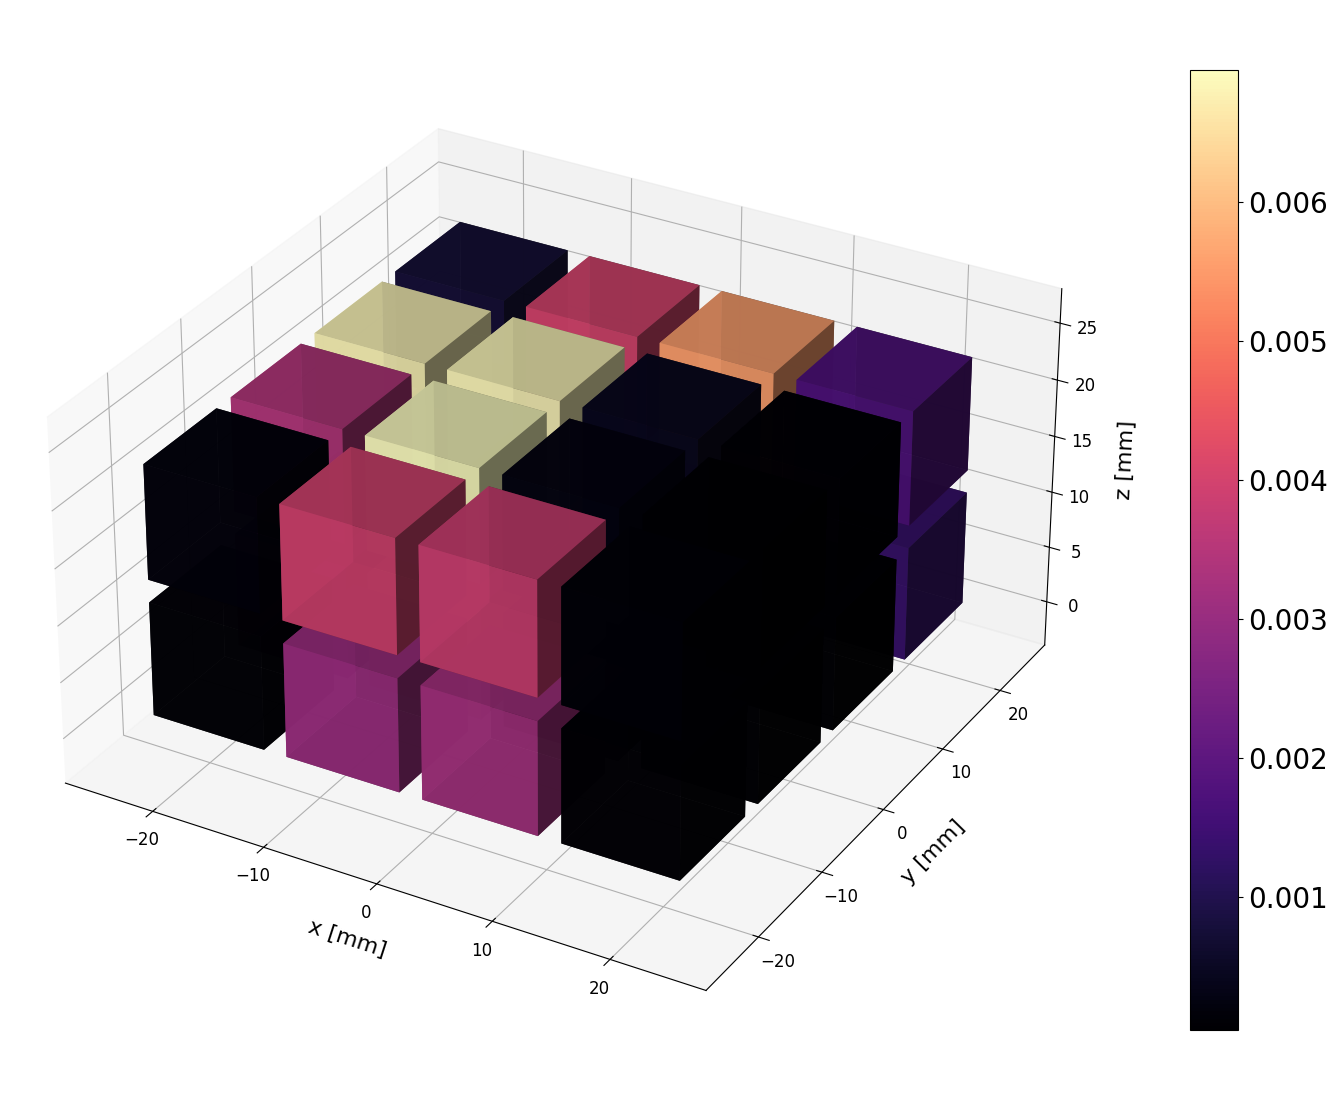

In [3]:
import pandas as pd
import polars as pl
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

counter=0

def add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, min, max):
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

  global counter
  print(f"adding {counter} voxel...")
  counter+=1
  
  # phantom_counts_norm = colors.LogNorm(vmin=min, vmax=max)
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)


if __name__ == "__main__":
  filename = "cp-0_d3ddetector_cell.csv"
  raw_df = pd.read_csv(filename)

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  voxel_side_len = 10
  observable = "Dose"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')
  
  df = sorted_df
  print(df)

  dose_max = df[observable].max()
  dose_min = df[df[observable]>0][observable].min()
  
  for _, row in df.iterrows():
      if row[observable] == 0:
          print(f"skipping row {row}")
          continue
      x_center = row['X [mm]']
      y_center = row['Y [mm]']
      z_center = row['Z [mm]']

      dose = row[observable]
      add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, dose_min, dose_max)

  # Ustawienie limitów osi
  x_min, x_max = df['X [mm]'].min() - voxel_side_len, df['X [mm]'].max() + voxel_side_len
  y_min, y_max = df['Y [mm]'].min() - voxel_side_len, df['Y [mm]'].max() + voxel_side_len
  z_min, z_max = df['Z [mm]'].min() - voxel_side_len, df['Z [mm]'].max() + voxel_side_len

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()